## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

def change_cmap_bkg_to_white(colormap, n=256):
    """
    Make any matplotlib colormap have a white background (i.e. any bins with 0 entries are colored white).
    This makes it easy to distinguish between bins with 0 entries and bins with only a few entries.
    
    Parameters
    ----------
    colormap : Colormap or str, optional
        A `.colors.Colormap` instance.  If not set, use rc settings.
    n : int
        The number of divisions of the color bar. 
        Use a higher number for a smoother transition of colors.
    """
    tmp_colors = cm.get_cmap(colormap, n)
    newcolors = tmp_colors(np.linspace(0, 1, n))
    white = np.array([1, 1, 1, 1])    # White background (Red, Green, Blue, Alpha).
    newcolors[0, :] = white    # Only change bins with 0 entries.
    newcmp = ListedColormap(newcolors)
    
    return newcmp

In [4]:
infile_r = None  # input file handle

#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc0.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc1.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc2.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc3.0.root'

#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc0.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc1.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc2.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc3.0.root'

#infile = '../test7/ntuple_SingleMuon_Endcap_200k.root'
infile = 'ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root'
infile_PU200 = None

def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='simhits', prefix='vc_', size='vc_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def load_pgun_PU200():
  print('[INFO] Opening file: %s' % infile_PU200)
  global infile_r
  infile_r = root_open(infile_PU200)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

In [5]:
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 25  # 5 (CSC) + 4 (RPC) + 3 (GEM) + *** ignore DT ***4 (DT)

zpositions = [599.0, 696.8, 696.8, 827.1, 827.1, 937.5, 937.5, 1027, 1027, 708.7, 708.7, 790.9, 790.9, 968.8, 968.8, 968.8, 1060, 1060, 1060, 566.4, 794.8, 539.3, 300, 300, 300, 300]

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 2  # ME1/3
    lut[1,2,1] = 3  # ME2/1
    lut[1,2,2] = 4  # ME2/2
    lut[1,3,1] = 5  # ME3/1
    lut[1,3,2] = 6  # ME3/2
    lut[1,4,1] = 7  # ME4/1
    lut[1,4,2] = 8  # ME4/2
    lut[2,1,2] = 9  # RE1/2
    lut[2,1,3] = 10  # RE1/3
    lut[2,2,2] = 11  # RE2/2
    lut[2,2,3] = 12  # RE2/3
    lut[2,3,1] = 13  # RE3/1
    lut[2,3,2] = 14  # RE3/2
    lut[2,3,3] = 15  # RE3/3
    lut[2,4,1] = 16  # RE4/1
    lut[2,4,2] = 17  # RE4/2
    lut[2,4,3] = 18  # RE4/3
    lut[3,1,1] = 19  # GE1/1
    lut[3,2,1] = 20 # GE2/1
    lut[4,1,1] = 21 # ME0
    lut[0,1,1] = 22 # MB1
    lut[0,2,1] = 23 # MB2
    lut[0,3,1] = 24 # MB3
    lut[0,4,1] = 25 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

eta_ranges = {
  'ME1/1' : [1.55, 2.5],
  'ME1/2' : [1.15, 1.7],
  'ME1/3' : [0.88, 1.12],
  'ME2/1' : [1.6, 2.5],
  'ME2/2' : [1.0, 2.5],
  'ME3/1' : [1.7, 2.5],
  'ME3/2' : [1.1, 1.7],
  'ME4/1' : [1.8, 2.5],
  'ME4/2' : [1.18, 1.8],
  'RE1/2' : [1.2, 1.7],
  'RE1/3' : [1.2, 1.7],
  'RE2/2' : [1.2, 1.6],
  'RE2/3' : [1.0, 1.2],
  'RE3/1' : [1.8, 2.5],
  'RE3/2' : [1.1, 1.4],
  'RE3/3' : [1.4, 1.8],
  'RE4/1' : [1.9, 2.5],
  'RE4/2' : [1.5, 1.8],
  'RE4/3' : [1.2, 1.5],
  'GE1'   : [1.5, 2.1],
  'GE2'   : [1.6, 2.4],
  'ME0'   : [2.0, 2.8],
  'MB1'   : [0.3, 0.8],
  'MB2'   : [0.3, 0.7],
  'MB3'   : [0.2, 0.6],
  'MB4'   : [0.2, 0.5],
}  
  
find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

In [6]:
def calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Propagate to station 2 (z = 850 cm), find r and eta of the track
  # (called rstar and etastar).
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  if eta < 0:
    zstar *= -1
  # Assume a simplified magnetic field where it is 4T (or 3.811T)
  # inside the solenoid and 0T outside (boundary at z = 650 cm)
  if eta < 0:
    zstar_4T *= -1
  B = 3.811
  R = -1.0 / (0.003 * B * invpt)  # R = -pT/(0.003 q B)  [cm], radius of the circle
  cot = np.sinh(eta)              # cot(theta), which is pz/pt
  if np.abs(zstar_4T) < np.abs(zstar):
    arg_term_4T = np.abs((zstar_4T - z0)/cot)                 # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = np.abs((zstar - zstar_4T)/cot)              # without magfield
    sin_term_0T = arg_term_0T                                 # without magfield
    cos_term_0T = 0                                           # without magfield
  else:
    # Also need to check for the boundary at r where 4T -> 0T, ignore for now
    arg_term_4T = np.abs((zstar - z0)/cot)                    # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = 0                                           # without magfield
    sin_term_0T = 0                                           # without magfield
    cos_term_0T = 0                                           # without magfield
  phistar_4T = phi + arg_term_4T/(2 * R)  # phi at the boundary where 4T -> 0T
  xstar = x0 + np.cos(phi) * sin_term_4T - np.sin(phi) * cos_term_4T + \
          np.cos(phistar_4T) * sin_term_0T - np.sin(phistar_4T) * cos_term_0T
  ystar = y0 + np.sin(phi) * sin_term_4T + np.cos(phi) * cos_term_4T + \
          np.sin(phistar_4T) * sin_term_0T + np.cos(phistar_4T) * cos_term_0T
  rstar = np.hypot(xstar, ystar)
  cotstar = zstar/rstar
  etastar = np.arcsinh(cotstar)
  return etastar

def calc_signed_rvtx(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Sign is positive if |etastar| <= |eta|, negative otherwise
  etastar = calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar, zstar_4T)
  rvtx = np.hypot(x0, y0)
  if not (np.abs(etastar) <= np.abs(eta)):
    rvtx *= -1
  return rvtx

## Main function

In [7]:
tree = load_pgun()
tree.Show(0)

[INFO] Opening file: ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root
======> EVENT:0
 vh_endcap       = (vector<short>*)0x8359630
 vh_station      = (vector<short>*)0x8bc0d60
 vh_ring         = (vector<short>*)0x77e0b50
 vh_sector       = (vector<short>*)0x8ba2ad0
 vh_subsector    = (vector<short>*)0x8b0bd80
 vh_chamber      = (vector<short>*)0x8bc27b0
 vh_cscid        = (vector<short>*)0x8baf4e0
 vh_bx           = (vector<short>*)0x8be5d50
 vh_type         = (vector<short>*)0x8baf2f0
 vh_neighbor     = (vector<short>*)0x8bb4140
 vh_strip        = (vector<short>*)0x8be57d0
 vh_wire         = (vector<short>*)0x8baf230
 vh_roll         = (vector<short>*)0x8bca2e0
 vh_quality      = (vector<short>*)0x8bbff80
 vh_pattern      = (vector<short>*)0x8bd2e50
 vh_bend         = (vector<short>*)0x77f5b80
 vh_time         = (vector<short>*)0x8bbb0d0
 vh_fr           = (vector<short>*)0x8bb6960
 vh_emtf_phi     = (vector<int>*)0x8bd3fd0
 vh_emtf_theta   = (vector<int>*)0x8bd42c0
 vh_

In [8]:
# Main function

def analysis(pileup=0):
  # Load tree
  if pileup == 200:
    tree = load_pgun_PU200()
  else:
    tree = load_pgun()
  
  # Event range
  #maxEvents = 100000
  maxEvents = 2000000
  
  # Output
  out_part_invpt, out_part_d0, out_part_eta, out_part_etastar = [], [], [], []
  out_hits_xmask, out_hits_etastar, out_hits_rvtx = [], [], []
  out_hits_rdphidz, out_hits_drdz = [], []
  
  # ____________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events without particles
    if len(evt.particles) == 0:
      continue
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits - NOT APPLIED
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    # __________________________________________________________________________
    # Muon parameters
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    part.etastar = calc_etastar_from_eta(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz)
    part.rvtx = calc_signed_rvtx(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz)
    
    # Skip low pT muons - NOT APPLIED
    #if part.pt < 20:
    #  continue
    
    # Skip large r_vtx muons
    if np.hypot(part.vx, part.vy) > 150:
      continue
    
    # Use sim_tp == 1 only - NOT APPLIED
    f = lambda hit: (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)
    #selected_hits = filter(f, evt.hits)
    
    selected_hits = evt.hits
    
    # __________________________________________________________________________
    # Trigger primitive variables
    
    # Boolean mask array. For each station, check if there exists at least a trigger primitive.
    # 1: does not exist (default) 0: exists
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # eta & etastar
    x_etastar_array = np.zeros((nlayers,), dtype=np.float32)
    x_rvtx_array = np.zeros((nlayers,), dtype=np.float32)
    for lay in range(nlayers):
      x_etastar_array[lay] = calc_etastar_from_eta(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz, zpositions[lay])
      x_rvtx_array[lay] = calc_signed_rvtx(part.invpt, part.eta, part.phi, part.vx, part.vy, part.vz, zpositions[lay])
    
    # local direction (from simhits)
    simhits_by_lay = np.empty((nlayers,), dtype=np.object)  # array of list (list of simhits)
    for lay in range(nlayers):
      simhits_by_lay[lay] = []
    
    for isimhit, simhit in enumerate(evt.simhits):
      lay = find_emtf_layer(simhit)
      coord = (simhit.phi, simhit.r, simhit.z)  # (phi,r,z)
      simhits_by_lay[lay].append(coord)
    
    x_rdphidz_array = np.zeros((nlayers,), dtype=np.float32) + np.nan
    x_drdz_array = np.zeros((nlayers,), dtype=np.float32) + np.nan
    for lay in range(nlayers):
      if len(simhits_by_lay[lay]) > 1:  # at least 2 simhits exist in station
        coords = np.asarray(simhits_by_lay[lay])
        ind = np.argsort(np.abs(coords[:,2]))  # sort coords by |z|
        phi0, r0, z0 = coords[ind[0]]
        phi1, r1, z1 = coords[ind[-1]]
        if np.abs(z1 - z0):  # avoids division by zero
          rdphidz = (r1*phi1 - r0*phi0) / (z1 - z0)
          drdz = (r1 - r0) / (z1 - z0)
          x_rdphidz_array[lay] = rdphidz
          x_drdz_array[lay] = drdz
    
    # Additional fix for RPC
    for lay in [5,6,7,8]:
      if len(simhits_by_lay[lay]) > 0:  # at least 1 simhit exist in station
        # The RPC detectors are close to their partner CSC detectors
        # So "borrow" the angles of incidence from CSC [1,2,3,4]
        x_rdphidz_array[lay] = x_rdphidz_array[lay-4]
        x_drdz_array[lay] = x_drdz_array[lay-4]
    
    # __________________________________________________________________________
    # Output
    
    out_part_invpt.append(part.invpt)
    out_part_d0.append(part.d0)
    out_part_eta.append(part.eta)
    out_part_etastar.append(part.etastar)
    out_hits_xmask.append(x_mask_array)
    out_hits_etastar.append(x_etastar_array)
    out_hits_rvtx.append(x_rvtx_array)
    out_hits_rdphidz.append(x_rdphidz_array)
    out_hits_drdz.append(x_drdz_array)
    
    continue  # end loop over events

  print("DONE")
  
  # Convert from lists into np arrays
  asarr = np.asarray
  res = (asarr(out_part_invpt), asarr(out_part_d0), asarr(out_part_eta), asarr(out_part_etastar),
         asarr(out_hits_xmask), asarr(out_hits_etastar), asarr(out_hits_rvtx),
         asarr(out_hits_rdphidz), asarr(out_hits_drdz),)
  return res

## Run analysis

In [9]:
# %%time

res = analysis()

(out_part_invpt, out_part_d0, out_part_eta, out_part_etastar, 
 out_hits_xmask, out_hits_etastar, out_hits_rvtx,
 out_hits_rdphidz, out_hits_drdz) = res

[INFO] Opening file: ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root
Processing event: 0
Processing event: 100000
Processing event: 200000
Processing event: 300000
Processing event: 400000
Processing event: 500000
Processing event: 600000
Processing event: 700000
Processing event: 800000
Processing event: 900000
Processing event: 1000000
Processing event: 1100000
Processing event: 1200000
Processing event: 1300000
Processing event: 1400000
Processing event: 1500000
Processing event: 1600000
Processing event: 1700000
Processing event: 1800000
Processing event: 1900000
DONE


In [10]:
# Verbose
print(out_part_invpt.shape, out_part_d0.shape, out_part_eta.shape, out_part_etastar.shape, out_part_invpt.dtype, out_part_d0.dtype, out_part_eta.dtype, out_part_etastar.dtype)
print(out_hits_xmask.shape, out_hits_etastar.shape, out_hits_rvtx.shape, out_hits_xmask.dtype, out_hits_etastar.dtype, out_hits_rvtx.dtype)

((583269,), (583269,), (583269,), (583269,), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))
((583269, 25), (583269, 25), (583269, 25), dtype('int32'), dtype('float32'), dtype('float32'))


## More setup

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [12]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [13]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, colorbar=False, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), **kwargs)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges, **kwargs)
  return h, edges, patches

In [14]:
class divide_context(object):
  """Context manager that avoids division by zero.
  
  Handle zeros in the denominator, replacing them by ones.
  Based on contextlib.nullcontext(enter_result=None)
  """

  def __init__(self, enter_result=None):
    self.enter_result = enter_result.copy()
    self.enter_result[self.enter_result == 0] = 1
  def __enter__(self):
    return self.enter_result
  def __exit__(self, *excinfo):
    pass

In [15]:
def decorate_hist(vlines=True, hlines=True):
  if vlines:
    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
      ax.plot([x,x], [ymin,ymax], '--', color='grey', lw=0.9)
  if hlines:
    for y in [0.95]:  # horizontal lines
      ax.plot([xmin,xmax], [y,y], '--', color='grey', lw=0.9)
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

def decorate_hist2d(vlines=True):
  if vlines:
    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
      ax.plot([x,x], [ymin,ymax], '--', color='grey', lw=0.9)
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

## Results (pT > 20 GeV)

In [16]:
# Prepare arrays

# stations = ['ME1/1','ME1/2','ME2','ME3','ME4','RE1','RE2','RE3','RE4','GE1','GE2','ME0','MB1','MB2','MB3','MB4']
stations = ['ME1/1', 'ME1/2', 'ME1/3','ME2/1','ME2/2','ME3/1','ME3/2','ME4/1','ME4/2','RE1/2','RE1/3',
            'RE2/2','RE2/3','RE3/1','RE3/2','RE3/3','RE4/1','RE4/2','RE4/3','GE1','GE2','ME0','MB1','MB2','MB3','MB4']

print np.shape(stations)

x_mask_array = out_hits_xmask.astype(np.bool, copy=True)
x_eta_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_eta[:,np.newaxis]
x_d0_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_d0[:,np.newaxis]
x_etastar_array = out_hits_etastar.copy()
x_rvtx_array = out_hits_rvtx.copy()

# print x_d0_array.shape

cut_pt20 = np.abs(out_part_invpt) < (1.0/20)
x_mask_array = x_mask_array[cut_pt20]
x_eta_array = x_eta_array[cut_pt20]
x_d0_array = x_d0_array[cut_pt20]
x_etastar_array = x_etastar_array[cut_pt20]
x_rvtx_array = x_rvtx_array[cut_pt20]

(26,)


In [ ]:
print x_mask_array.shape
print x_d0_array.shape
print x_eta_array.shape
print x_etastar_array.shape
print cut_pt20.shape

In [ ]:
# Efficiency vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'purple'

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(eta, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(eta[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
  hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
  hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist()

plt.show()

In [ ]:
# Efficiency vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'purple'

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(eta, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(eta[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
  hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
  hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist()

plt.show()

In [ ]:
# 2D efficiency d0 vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  d0 = x_d0_array[...,i]  # d0
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

In [ ]:
# 2D efficiency d0 vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  d0 = x_d0_array[...,i]  # d0
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

In [ ]:
# 2D efficiency r_vtx vs eta (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  d0 = x_rvtx_array[...,i]  # r_vtx
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

In [ ]:
# 2D efficiency r_vtx vs etastar (pT > 20 GeV)

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -150.0, 150.0
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  d0 = x_rvtx_array[...,i]  # r_vtx
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, d0, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], d0[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

## Results (pT > 0 GeV)

In [ ]:
# Prepare arrays

x_mask_array = out_hits_xmask.astype(np.bool, copy=True)
x_eta_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_eta[:,np.newaxis]
x_d0_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_d0[:,np.newaxis]
x_etastar_array = out_hits_etastar.copy()
x_rvtx_array = out_hits_rvtx.copy()

x_invpt_array = np.ones(x_mask_array.shape, dtype=np.float32) * out_part_invpt[:,np.newaxis]

In [ ]:
# 2D efficiency q/pT vs eta

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -0.5, 0.5
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_eta_array[...,i])  # |eta|
  invpt = x_invpt_array[...,i]  # q/pT
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, invpt, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], invpt[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

In [ ]:
# 2D efficiency q/pT vs etastar

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = 0.7, 3.0
ymin, ymax = -0.5, 0.5
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  eta = np.abs(x_etastar_array[...,i])  # |etastar|
  invpt = x_invpt_array[...,i]  # q/pT
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(eta, invpt, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(eta[passed], invpt[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  ax.text(0.85,0.98,stations[i],weight='bold')
  
  # Decorate
  decorate_hist2d()

plt.show()

## Results (angle of incidence)

In [17]:
# Prepare arrays

x_mask_array = out_hits_xmask.astype(np.bool, copy=True)
x_etastar_array = out_hits_etastar.copy()

x_rdphidz_array = out_hits_rdphidz.copy()
x_drdz_array = out_hits_drdz.copy()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.16.2-pafccj/lib/python2.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.16.2-pafccj/lib/python2.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that ar

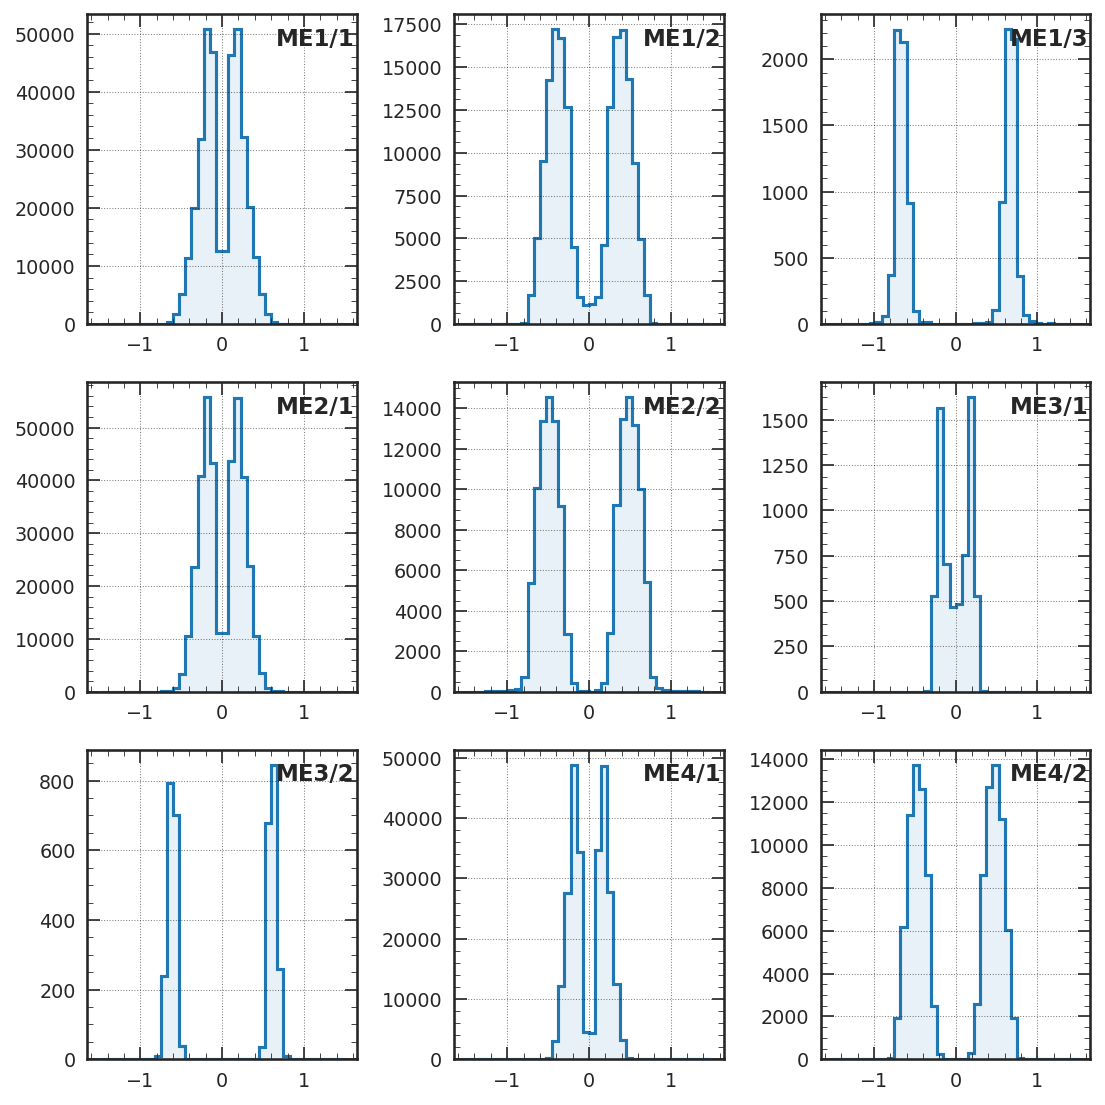

In [18]:
# Distribution of angle of incidence (longitudinal)
################## without detector mask

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
nbinsx = 40
color = 'C0'

count = 0
# Loop over each station
for i in range(9):
#   detector_mask = 
  angle = x_drdz_array[...,i]  # dr/dz
  
  
  # Note: dr/dz ~ 0 means parallel to beam line. The valley there is
  # due to the fact that the muons were only generated up to eta=2.8
  
  # Draw
  count += 1
#   try:
#   print i/ncols,i%ncols
  ax = axs[i/ncols,i%ncols]
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
  if i < 3: x = 0.70
  else: x = 0.70
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
#   except: pass
  
  

plt.show()

# RPC

In [ ]:
# Distribution of angle of incidence (longitudinal)
# with detector mask

nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
nbinsx = 40
color = 'C0'

count = 0
# Loop over each station
for i in np.arange(9,19,1):
#   detector_mask = 
  angle = x_drdz_array[...,i]  # dr/dz
  detector_mask = np.logical_and(np.abs(out_hits_etastar[...,i]) > eta_ranges[stations[i]][0], np.abs(out_hits_etastar[...,i]) < eta_ranges[stations[i]][1])
  
  
  # Note: dr/dz ~ 0 means parallel to beam line. The valley there is
  # due to the fact that the muons were only generated up to eta=2.8
  
  # Draw
  count += 1
#   try:
#   print i/ncols,i%ncols
  ax = axs[(i-9)/ncols,(i-9)%ncols]
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
  if i < 3: x = 0.70
  else: x = 0.70
  eta_info = [eta_ranges[stations[i]][0], eta_ranges[stations[i]][1]]
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  ax.text(x,0.05,eta_info, transform=ax.transAxes)
#   except: pass

  

plt.show()

# GEM

In [ ]:
# Distribution of angle of incidence (longitudinal)
# with detector mask

nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
nbinsx = 40
color = 'C0'

count = 0
# Loop over each station
for i in np.arange(19,21,1):
#   detector_mask = 
  angle = x_drdz_array[...,i]  # dr/dz
  detector_mask = np.logical_and(np.abs(out_hits_etastar[...,i]) > eta_ranges[stations[i]][0], np.abs(out_hits_etastar[...,i]) < eta_ranges[stations[i]][1])
  
  
  # Note: dr/dz ~ 0 means parallel to beam line. The valley there is
  # due to the fact that the muons were only generated up to eta=2.8
  
  # Draw
  count += 1
#   try:
#   print i/ncols,i%ncols
  ax = axs[i-19]
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
  _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
  if i < 3: x = 0.70
  else: x = 0.70
  eta_info = [eta_ranges[stations[i]][0], eta_ranges[stations[i]][1]]
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  ax.text(x,0.05,eta_info, transform=ax.transAxes)
#   except: pass

  

plt.show()

In [ ]:
# Distribution of angle of incidence (transverse)

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -3., 3.
nbinsx = 40
color = 'C0'

angle = x_drdz_array[...,21]  # dphi/dz
  
# Draw
ax = axs
_ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
_ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
if i < 3: x = 0.70
else: x = 0.75
ax.text(x,0.90,stations[21],weight='bold', transform=ax.transAxes)

# # Loop over each station
# for i in range(9):
#   angle = x_rdphidz_array[...,i]  # dphi/dz
  
#   # Draw
#   ax = axs[i/ncols,i%ncols]
#   _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
#   _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
#   if i < 3: x = 0.70
#   else: x = 0.75
#   ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)

plt.show()

In [ ]:
# Distribution of angle of incidence (transverse)

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -3., 3.
nbinsx = 40
color = 'C0'

angle = x_rdphidz_array[...,21]  # dphi/dz
  
# Draw
ax = axs
_ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
_ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
if i < 3: x = 0.70
else: x = 0.75
ax.text(x,0.90,stations[21],weight='bold', transform=ax.transAxes)

# # Loop over each station
# for i in range(9):
#   angle = x_rdphidz_array[...,i]  # dphi/dz
  
#   # Draw
#   ax = axs[i/ncols,i%ncols]
#   _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, lw=1.5, histtype='step')
#   _ = ax.hist(angle, bins=nbinsx, range=(xmin,xmax), color=color, alpha=0.1, histtype='stepfilled')
#   if i < 3: x = 0.70
#   else: x = 0.75
#   ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)

plt.show()

In [ ]:
import matplotlib.colors as colors

In [ ]:
# Distribution of angle of incidence (longitudinal & transverse)

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = -3., 3.
nbinsx = 40
nbinsy = 20
cmap = change_cmap_bkg_to_white('rainbow')

# Loop over each station
for i in range(9):
  angle1 = x_drdz_array[...,i]  # drdz
  angle2 = x_rdphidz_array[...,i]  # r dphi/dz
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  if i < 15: norm = colors.LogNorm()
  else: norm = None
  h, xedges, yedges, im = ax.hist2d(angle1, angle2, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)), cmap=cmap, norm=norm)
  cb = ax.figure.colorbar(im, ax=ax)
  ax.text(0.05,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  # Decorate
  decorate_hist2d(vlines=False)

plt.show()

In [ ]:
# Efficiency vs angle of incidence (longitudinal)
# without detector mask

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'C0'

# Loop over each station
for i in range(9):
  mask = out_hits_xmask.astype(np.bool, copy=True)[...,i]
#   mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  angle = x_drdz_array[...,i]  # dr/dz

  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(angle, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(angle[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
#   hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
#   hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  if i < 3: x = 0.70
  else: x = 0.75
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  x = (edges[1:] + edges[:-1])/2
  err = np.sqrt(eff_hist*(1-eff_hist) / denom_hist)
  ax.errorbar(x, eff_hist, yerr=err, color=color, ecolor=color, drawstyle='steps-mid')
  # Decorate
  decorate_hist(vlines=False)

plt.show()

In [ ]:
# Efficiency vs angle of incidence (longitudinal)
# without detector mask

nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'C0'

# Loop over each station
for i in np.arange(9,19,1):
  mask = out_hits_xmask.astype(np.bool, copy=True)[...,i]
#   mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  angle = x_drdz_array[...,i]  # dr/dz

  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(angle, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(angle[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[(i-9)/ncols,(i-9)%ncols]
#   hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
#   hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  if i < 3: x = 0.70
  else: x = 0.75
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  x = (edges[1:] + edges[:-1])/2
  err = np.sqrt(eff_hist*(1-eff_hist) / denom_hist)
  ax.errorbar(x, eff_hist, yerr=err, color=color, ecolor=color, drawstyle='steps-mid')
  # Decorate
  decorate_hist(vlines=False)

plt.show()

In [ ]:
# Efficiency vs angle of incidence (longitudinal)
# without detector mask

nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'C0'

# Loop over each station
for i in np.arange(19,21,1):
  mask = out_hits_xmask.astype(np.bool, copy=True)[...,i]
#   mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  angle = x_drdz_array[...,i]  # dr/dz

  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(angle, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(angle[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[(i-18)%ncols]
#   hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
#   hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  if i < 3: x = 0.70
  else: x = 0.75
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  x = (edges[1:] + edges[:-1])/2
  err = np.sqrt(eff_hist*(1-eff_hist) / denom_hist)
  ax.errorbar(x, eff_hist, yerr=err, color=color, ecolor=color, drawstyle='steps-mid')
  # Decorate
  decorate_hist(vlines=False)

plt.show()

In [ ]:
# Efficiency vs angle of incidence (longitudinal)
# without detector mask

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'C0'


mask = out_hits_xmask.astype(np.bool, copy=True)[...,21]
#   mask = x_mask_array[...,i]
passed = ~mask  # trigger primitive exists in station

angle = x_drdz_array[...,21]  # dr/dz


# Calculate eff = num/denom
denom_hist, edges = np.histogram(angle, bins=nbinsx, range=(xmin,xmax))
print denom_hist
num_hist, edges = np.histogram(angle[passed], bins=nbinsx, range=(xmin,xmax))
with divide_context(denom_hist) as denom_hist_nozeros:
  eff_hist = np.true_divide(num_hist, denom_hist_nozeros)

# Draw it twice - once for line histogram, and once for filled histogram
#   hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
#   hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
if i < 3: x = 0.70
else: x = 0.75
ax.text(x,0.90,stations[21],weight='bold', transform=ax.transAxes)

x = (edges[1:] + edges[:-1])/2
err = np.sqrt(eff_hist*(1-eff_hist) / denom_hist)
ax.errorbar(x, eff_hist, yerr=err, color=color, ecolor=color, drawstyle='steps-mid')
# Decorate
decorate_hist(vlines=False)

plt.show()

In [ ]:
# Efficiency vs angle of incidence (transverse)

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -3., 3.
ymin, ymax = 0, 1.05
nbinsx = 40
color = 'C1'

# Loop over each station
for i in range(9):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  angle = x_rdphidz_array[...,i]  # r dphi/dz
  
  # Calculate eff = num/denom
  denom_hist, edges = np.histogram(angle, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(angle[passed], bins=nbinsx, range=(xmin,xmax))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw it twice - once for line histogram, and once for filled histogram
  ax = axs[i/ncols,i%ncols]
#   hist_on_binned_array(eff_hist, edges, color=color, lw=1.5, histtype='step', ax=ax)
#   hist_on_binned_array(eff_hist, edges, color=color, alpha=0.1, histtype='stepfilled', ax=ax)
  if i < 3: x = 0.70
  else: x = 0.75
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  x = (edges[1:] + edges[:-1])/2
  err = np.sqrt(eff_hist*(1-eff_hist) / denom_hist)
  ax.errorbar(x, eff_hist, yerr=err, color=color, ecolor=color, drawstyle='steps-mid')
  
  # Decorate
  decorate_hist(vlines=False)

plt.show()

In [ ]:
print np.shape(x_drdz_array)
print np.shape(x_rdphidz_array)
print np.shape(x_d0_array)


In [ ]:
# 2D efficiency r dphidz vs drdz

nrows, ncols = 6, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

xmin, xmax = -1.5, 1.5
ymin, ymax = -3., 3.
nbinsx = 40
nbinsy = 20
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers-3):
  mask = x_mask_array[...,i]
  passed = ~mask  # trigger primitive exists in station
  
  angle1 = x_drdz_array[...,i]  # drdz
  angle2 = x_rdphidz_array[...,i]  # r dphi/dz
  
  # Calculate eff = num/denom
  denom_hist, xedges, yedges = np.histogram2d(angle1, angle2, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  num_hist, xedges, yedges = np.histogram2d(angle1[passed], angle2[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
  with divide_context(denom_hist) as denom_hist_nozeros:
    eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  if i < 3: x = 0.35
  else: x = 0.4
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  # Decorate
  decorate_hist2d(vlines=False)

plt.show()


In [ ]:
# 2D correlation between d0 and drdz

nrows, ncols = 6, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

# xmin, xmax = -1.5, 1.5
# ymin, ymax = -3., 3.
ymin, ymax = -1.5, 1.5
xmin, xmax = -150., 150.
nbinsx = 20
nbinsy = 100
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers-3):
#   mask = x_mask_array[...,i]
#   passed = ~mask  # trigger primitive exists in station
  
  angle = x_drdz_array[...,i]  # drdz
  d0 = x_d0_array[...,i]  # r dphi/dz
  
  # Calculate eff = num/denom
#   denom_hist, xedges, yedges = np.histogram2d(angle1, angle2, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
#   num_hist, xedges, yedges = np.histogram2d(angle1[passed], angle2[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
#   with divide_context(denom_hist) as denom_hist_nozeros:
#     eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  cmap = change_cmap_bkg_to_white('rainbow')
  h, xedges, yedges, im = ax.hist2d(out_part_d0, angle, range=[[xmin, xmax], [ymin, ymax]], cmap=cmap, bins=[nbinsx, nbinsy])
  cb = ax.figure.colorbar(im, ax=ax)
#   hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  if i < 3: x = 0.35
  else: x = 0.4
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  # Decorate
  decorate_hist2d(vlines=False)

plt.show()

In [ ]:
# 2D correlation between d0 and r dphidz

nrows, ncols = 6, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5), tight_layout=True)

# xmin, xmax = -1.5, 1.5
ymin, ymax = -3., 3.
# ymin, ymax = -1.5, 1.5
xmin, xmax = -150., 150.
nbinsx = 40
nbinsy = 200
cmap = plt.cm.Greens

# Loop over each station
for i in range(nlayers-3):
#   mask = x_mask_array[...,i]
#   passed = ~mask  # trigger primitive exists in station
  
  angle = x_rdphidz_array[...,i]  # drdz
  d0 = x_d0_array[...,i]  # r dphi/dz
  
  # Calculate eff = num/denom
#   denom_hist, xedges, yedges = np.histogram2d(angle1, angle2, bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
#   num_hist, xedges, yedges = np.histogram2d(angle1[passed], angle2[passed], bins=(nbinsx,nbinsy), range=((xmin,xmax),(ymin,ymax)))
#   with divide_context(denom_hist) as denom_hist_nozeros:
#     eff_hist = np.true_divide(num_hist, denom_hist_nozeros)
  
  # Draw
  ax = axs[i/ncols,i%ncols]
  cmap = change_cmap_bkg_to_white('rainbow')
  h, xedges, yedges, im = ax.hist2d(out_part_d0, angle, range=[[xmin, xmax], [ymin, ymax]], cmap=cmap, bins=[nbinsx, nbinsy])
  cb = ax.figure.colorbar(im, ax=ax)
#   hist2d_on_binned_array(eff_hist, xedges, yedges, cmap=cmap, colorbar=True, vmin=0.0, vmax=1.05, ax=ax)
  if i < 3: x = 0.35
  else: x = 0.4
  ax.text(x,0.90,stations[i],weight='bold', transform=ax.transAxes)
  
  # Decorate
  decorate_hist2d(vlines=False)

plt.show()